In [1]:
import pandas as pd
import numpy as np
import io
from google.colab import files

print("Please upload all 6 CSV files now...")
uploaded = files.upload()

bge_files = ['20-21.csv', '21-22.csv', '22-23.csv', '23-24.csv', '24-25.csv']
bge_dfs = []

print("\nProcessing BGE Data (Concatenating 5 files)...")
for filename in bge_files:
    if filename in uploaded:
        df = pd.read_csv(io.BytesIO(uploaded[filename]))
        bge_dfs.append(df)
    else:
        print(f"WARNING: {filename} not found in uploaded files!")

if bge_dfs:
    bge_df = pd.concat(bge_dfs, ignore_index=True)
    bge_df['datetime_beginning_utc'] = pd.to_datetime(bge_df['datetime_beginning_utc'])
    bge_df = bge_df.set_index('datetime_beginning_utc').sort_index()
    bge_df = bge_df[['mw']]
    print("BGE Demand Data processed successfully.")
else:
    raise Exception("No BGE files were loaded. Please re-run and upload them.")

weather_file = 'BWI data 20-25 UTC.csv'
if weather_file in uploaded:
    print(f"\nProcessing {weather_file}...")
    wx_df = pd.read_csv(io.BytesIO(uploaded[weather_file]))

    wx_df['Time UTC'] = pd.to_datetime(wx_df['Time UTC']).dt.round('H')

    wx_numeric_cols = ['tmpf', 'relh', 'feel']
    for col in wx_numeric_cols:
        wx_df[col] = pd.to_numeric(wx_df[col], errors='coerce')

    wx_hourly = wx_df.groupby('Time UTC')[wx_numeric_cols].mean()
    print("BWI Weather Data processed and aggregated to hourly averages.")
else:
    raise Exception(f"{weather_file} not found! Please re-run and upload it.")

merged_df = bge_df.join(wx_hourly, how='inner')
merged_df.index.name = 'Time_UTC'

original_len = len(merged_df)

merged_df = merged_df[~merged_df.index.duplicated(keep='first')]

merged_df = merged_df[(merged_df['mw'] >= 0) & (merged_df['relh'] >= 0) & (merged_df['relh'] <= 100)]

merged_df = merged_df[(merged_df['tmpf'] > -20) & (merged_df['tmpf'] < 110)]

merged_df = merged_df[(merged_df['feel'] >= 0)]

merged_df = merged_df.dropna()

rows_dropped = original_len - len(merged_df)
print(f"\nFinal Merged Dataset created.")
print(f"Total rows dropped during cleaning (including negative 'feel'): {rows_dropped}")
print(f"Final usable rows for analysis: {len(merged_df)}")

print("\nFirst 5 rows of the final dataset:")
print(merged_df.head())
print("\nSummary Statistics of the final 'feel' column:")
print(merged_df['feel'].describe())

output_filename = 'final_bge_bwi_merged_cleaned_Final.csv'
merged_df.to_csv(output_filename)
print(f"\nSaving final dataset to {output_filename}...")

files.download(output_filename)

Please upload all 6 CSV files now...


Saving BWI data 20-25 UTC.csv to BWI data 20-25 UTC.csv
Saving 24-25.csv to 24-25.csv
Saving 23-24.csv to 23-24.csv
Saving 22-23.csv to 22-23.csv
Saving 21-22.csv to 21-22.csv
Saving 20-21.csv to 20-21.csv

Processing BGE Data (Concatenating 5 files)...
BGE Demand Data processed successfully.

Processing BWI data 20-25 UTC.csv...


/tmp/ipython-input-2989977122.py:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  wx_df['Time UTC'] = pd.to_datetime(wx_df['Time UTC']).dt.round('H')
/tmp/ipython-input-2989977122.py:46: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  wx_df['Time UTC'] = pd.to_datetime(wx_df['Time UTC']).dt.round('H')


BWI Weather Data processed and aggregated to hourly averages.

Final Merged Dataset created.
Total rows dropped during cleaning (including negative 'feel'): 32
Final usable rows for analysis: 43732

First 5 rows of the final dataset:
                           mw  tmpf   relh   feel
Time_UTC                                         
2020-11-01 04:00:00  2744.707  45.0  76.01  43.55
2020-11-01 05:00:00  2650.000  46.0  73.18  44.69
2020-11-01 06:00:00  2564.470  47.0  70.73  46.90
2020-11-01 07:00:00  2524.327  46.0  82.58  46.00
2020-11-01 08:00:00  2495.141  47.0  79.82  46.90

Summary Statistics of the final 'feel' column:
count    43732.000000
mean        57.579624
std         20.101087
min          0.270000
25%         41.260000
50%         59.000000
75%         73.000000
max        112.620000
Name: feel, dtype: float64

Saving final dataset to final_bge_bwi_merged_cleaned_Final.csv...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
import pandas as pd
import numpy as np

INPUT_FILE = 'Final.csv'
OUTPUT_FILE = 'yearly_summary_statistics.csv'
TEMP_CONVERSION_FACTOR = 5/9

def fahrenheit_to_celsius(f):
    """Converts Fahrenheit to Celsius, handling potential NaN/Null values."""
    return (f - 32) * TEMP_CONVERSION_FACTOR

try:
    df = pd.read_csv(INPUT_FILE)

    df['Time_UTC'] = pd.to_datetime(df['Time_UTC'])
    df = df.set_index('Time_UTC')

    df['tmpc'] = fahrenheit_to_celsius(df['tmpf'])

    df['Year'] = df.index.year

    agg_funcs = {
        'mw': ['mean', 'max'],
        'tmpc': ['mean', 'min', 'max'],
        'relh': ['mean', 'min', 'max'],
        'feel': ['mean', 'min', 'max']
    }

    yearly_summary = df.groupby('Year').agg(agg_funcs)

    yearly_summary.columns = [
        f'{col}_{stat}'.replace('tmpc_', 'temperature_c_').replace('relh_', 'rh_').replace('feel_', 'feel_f_')
        for col, stat in yearly_summary.columns
    ]

    yearly_summary = yearly_summary.rename(columns={
        'mw_mean': 'Demand Mean (MW)',
        'mw_max': 'Demand Max (MW)',
        'temperature_c_mean': 'Temp Mean (C)',
        'temperature_c_min': 'Temp Min (C)',
        'temperature_c_max': 'Temp Max (C)',
        'rh_mean': 'RH Mean (%)',
        'rh_min': 'RH Min (%)',
        'rh_max': 'RH Max (%)',
        'feel_f_mean': 'Feel Mean (F)',
        'feel_f_min': 'Feel Min (F)',
        'feel_f_max': 'Feel Max (F)',
    })

    column_order = [
        'Demand Mean (MW)', 'Demand Max (MW)',
        'Temp Mean (C)', 'Temp Min (C)', 'Temp Max (C)',
        'RH Mean (%)', 'RH Min (%)', 'RH Max (%)',
        'Feel Mean (F)', 'Feel Min (F)', 'Feel Max (F)',
    ]
    yearly_summary = yearly_summary[column_order]

    yearly_summary.to_csv(OUTPUT_FILE, float_format='%.2f')

    print(f"Success! The yearly summary statistics have been saved to '{OUTPUT_FILE}'.")
    print("\n--- Summary Table ---")
    print(yearly_summary.to_markdown())

except FileNotFoundError:
    print(f"Error: The input file '{INPUT_FILE}' was not found.")
except KeyError as e:
    print(f"Error: A required column was not found. Missing key: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Success! The yearly summary statistics have been saved to 'yearly_summary_statistics.csv'.

--- Summary Table ---
|   Year |   Demand Mean (MW) |   Demand Max (MW) |   Temp Mean (C) |   Temp Min (C) |   Temp Max (C) |   RH Mean (%) |   RH Min (%) |   RH Max (%) |   Feel Mean (F) |   Feel Min (F) |   Feel Max (F) |
|-------:|-------------------:|------------------:|----------------:|---------------:|---------------:|--------------:|-------------:|-------------:|----------------:|---------------:|---------------:|
|   2020 |            3374.32 |           5033.15 |         7.78432 |       -5       |        25.5556 |       63.6237 |        20.83 |      97.2333 |         43.5728 |          11.09 |         78.1   |
|   2021 |            3541.31 |           6485.98 |        14.9666  |       -6.72222 |        36.6667 |       62.9691 |        12.81 |     100      |         57.9591 |          10.03 |        107.81  |
|   2022 |            3544.02 |           6520.05 |        14.3266  |      -11

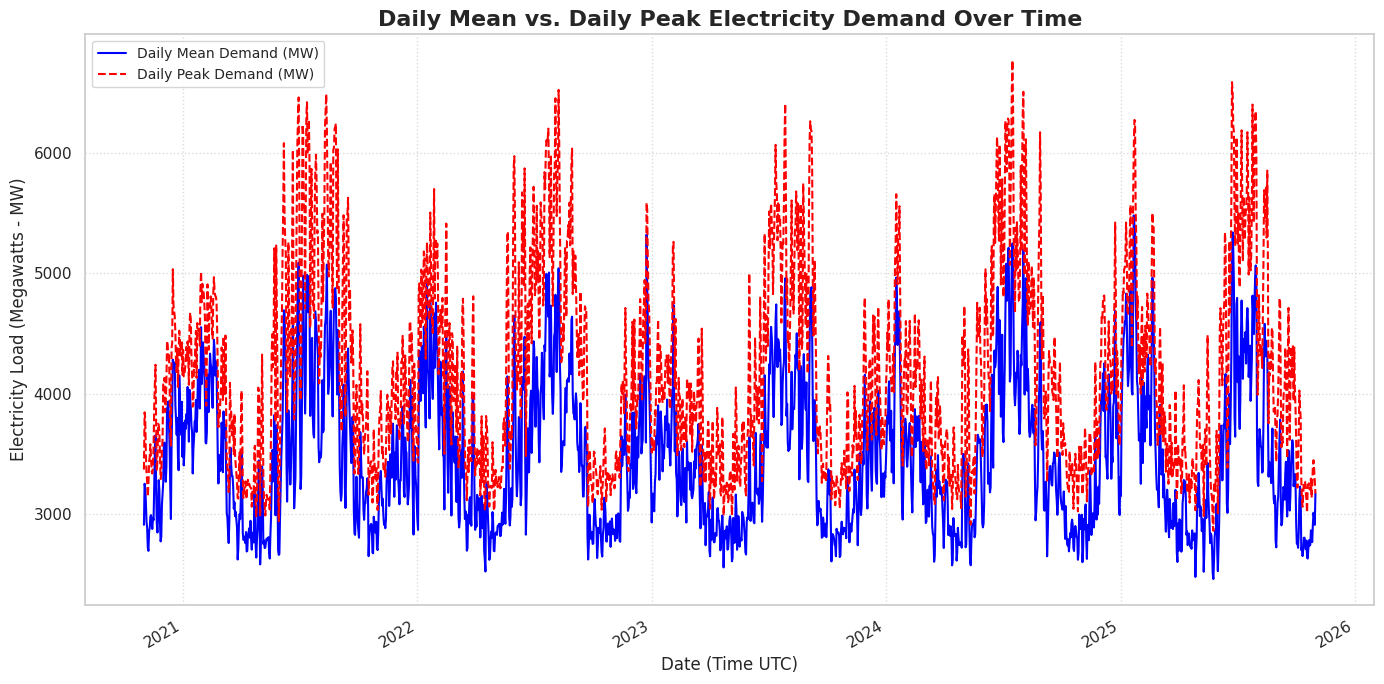

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

FILE_PATH = "Final.csv"

def plot_daily_demand_time_series(file_path):
    """
    Loads hourly load data, calculates daily mean and peak demand,
    and plots them as a time series.
    """
    try:

        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found. Please upload it to your Colab session.")
        return

    df['Time_UTC'] = pd.to_datetime(df['Time_UTC'])

    df.set_index('Time_UTC', inplace=True)

    df.dropna(subset=['mw'], inplace=True)

    daily_mean_demand = df['mw'].resample('D').mean()

    daily_peak_demand = df['mw'].resample('D').max()

    plt.figure(figsize=(14, 7))

    plt.plot(daily_mean_demand.index, daily_mean_demand.values,
             label='Daily Mean Demand (MW)',
             color='blue',
             linestyle='-')

    plt.plot(daily_peak_demand.index, daily_peak_demand.values,
             label='Daily Peak Demand (MW)',
             color='red',
             linestyle='--')

    plt.title('Daily Mean vs. Daily Peak Electricity Demand Over Time', fontsize=16, fontweight='bold')
    plt.xlabel('Date (Time UTC)', fontsize=12)
    plt.ylabel('Electricity Load (Megawatts - MW)', fontsize=12)

    plt.legend(fontsize=10)

    plt.gcf().autofmt_xdate()

    plt.grid(True, linestyle=':', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_daily_demand_time_series(FILE_PATH)

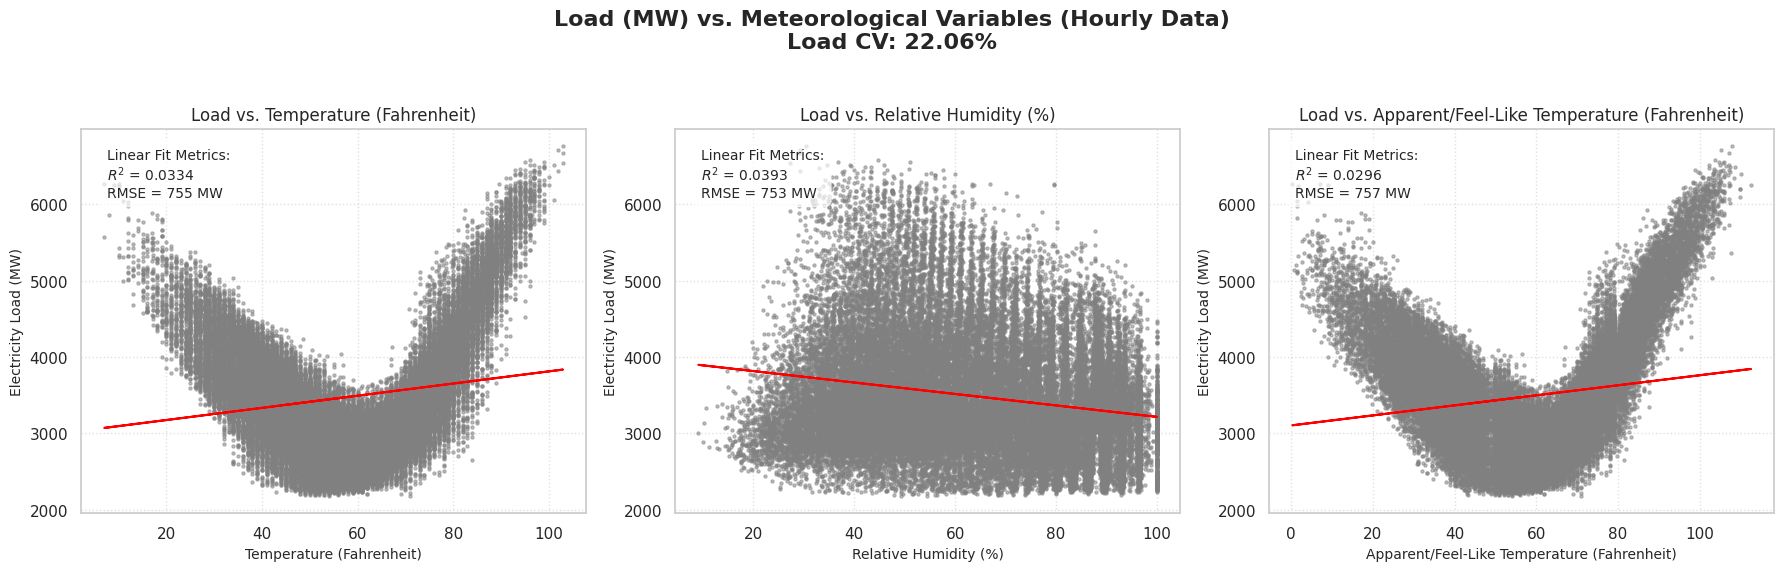

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.metrics import r2_score, mean_squared_error

FILE_PATH = "Final.csv"

def calculate_cv(data):
    """Calculate the Coefficient of Variation (CV) as StdDev / Mean."""
    return np.std(data) / np.mean(data) * 100

def plot_load_vs_meteorology(file_path):
    """
    Loads data, performs linear regression for 'mw' vs. key meteorology columns,
    and generates scatterplots with best-fit lines and key metrics.
    """
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found. Please upload it to your Colab session.")
        return

    meteorology_cols = ['tmpf', 'relh', 'feel']
    target_col = 'mw'

    df.dropna(subset=[target_col] + meteorology_cols, inplace=True)

    load_cv = calculate_cv(df[target_col])

    column_labels = {
        'tmpf': 'Temperature (Fahrenheit)',
        'relh': 'Relative Humidity (%)',
        'feel': 'Apparent/Feel-Like Temperature (Fahrenheit)'
    }

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    plt.suptitle(
        f'Load (MW) vs. Meteorological Variables (Hourly Data)\nLoad CV: {load_cv:.2f}%',
        fontsize=16,
        fontweight='bold'
    )

    for i, col in enumerate(meteorology_cols):
        X = df[col]
        Y = df[target_col]
        ax = axes[i]

        slope, intercept, r_value, p_value, std_err = linregress(X, Y)

        r_squared = r_value**2

        Y_predicted = slope * X + intercept
        rmse = np.sqrt(mean_squared_error(Y, Y_predicted))

        ax.scatter(X, Y, s=5, alpha=0.5, color='gray')

        ax.plot(X, Y_predicted,
                color='red',
                label=f'Best-Fit Line\n(y={slope:.2f}x + {intercept:.0f})')

        metric_text = (
            f"Linear Fit Metrics:\n"
            r"$R^2$" f" = {r_squared:.4f}\n"
            f"RMSE = {rmse:.0f} MW"
        )
        ax.text(0.05, 0.95, metric_text, transform=ax.transAxes,
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.7))

        ax.set_title(f'Load vs. {column_labels[col]}', fontsize=12)
        ax.set_xlabel(column_labels[col], fontsize=10)
        ax.set_ylabel('Electricity Load (MW)', fontsize=10)
        ax.grid(True, linestyle=':', alpha=0.6)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_load_vs_meteorology(FILE_PATH)

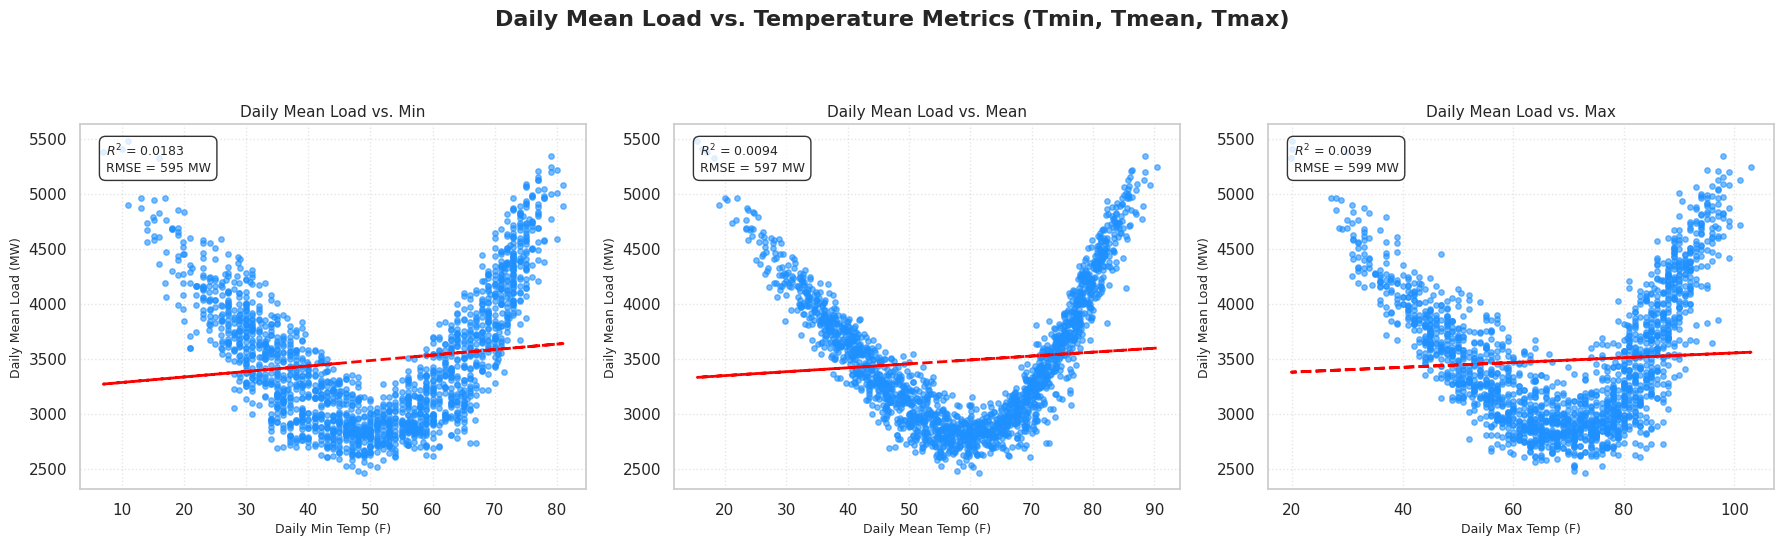

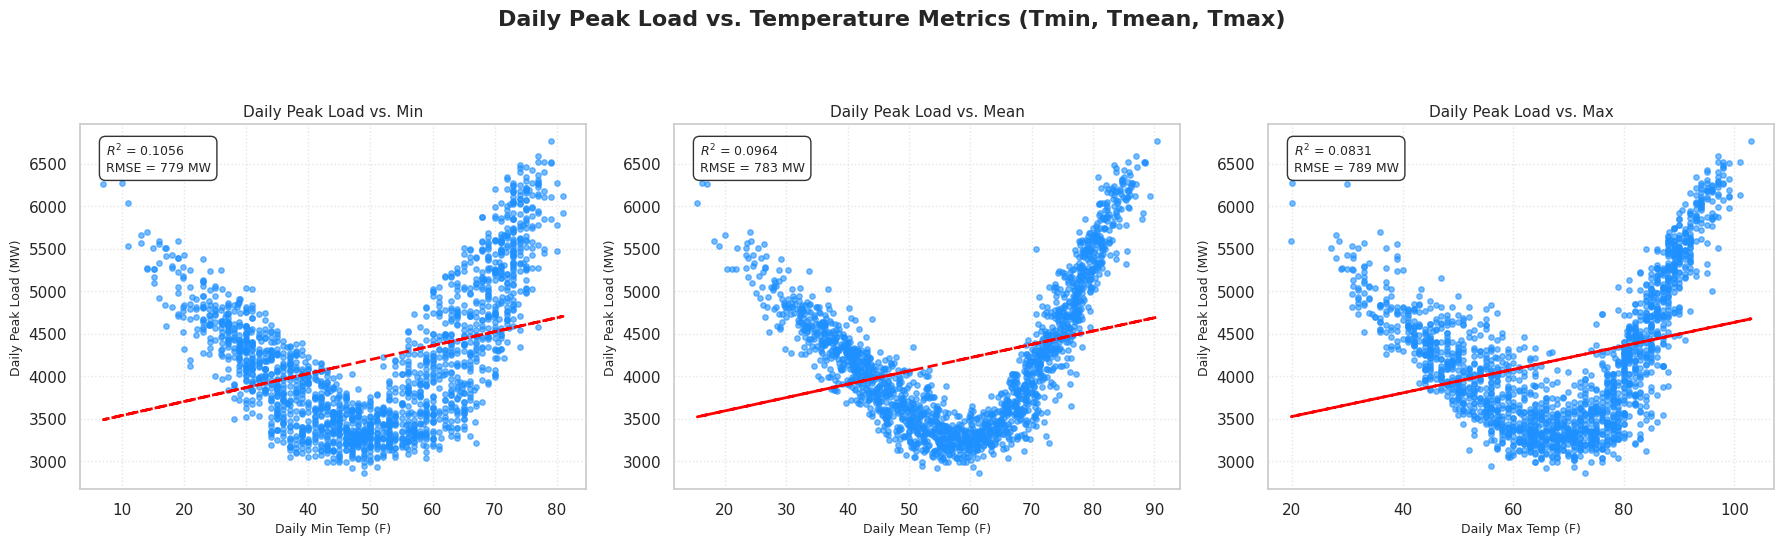

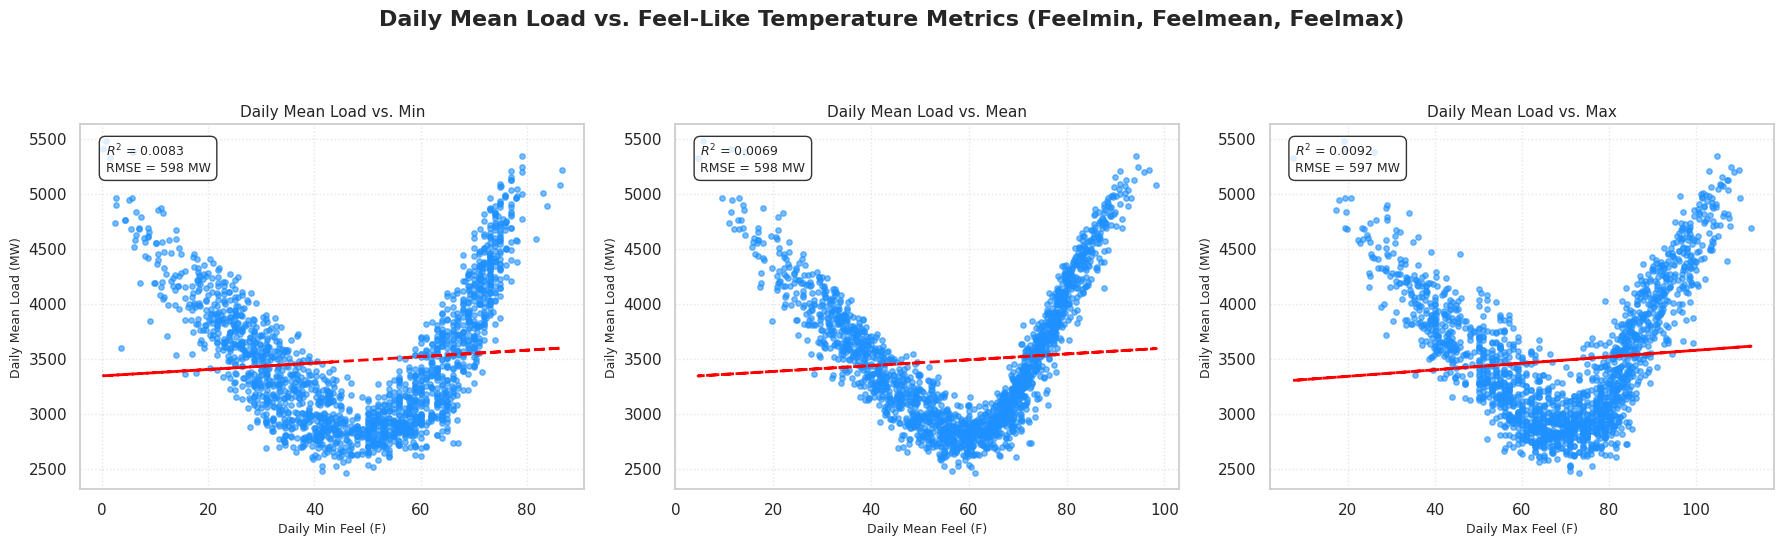

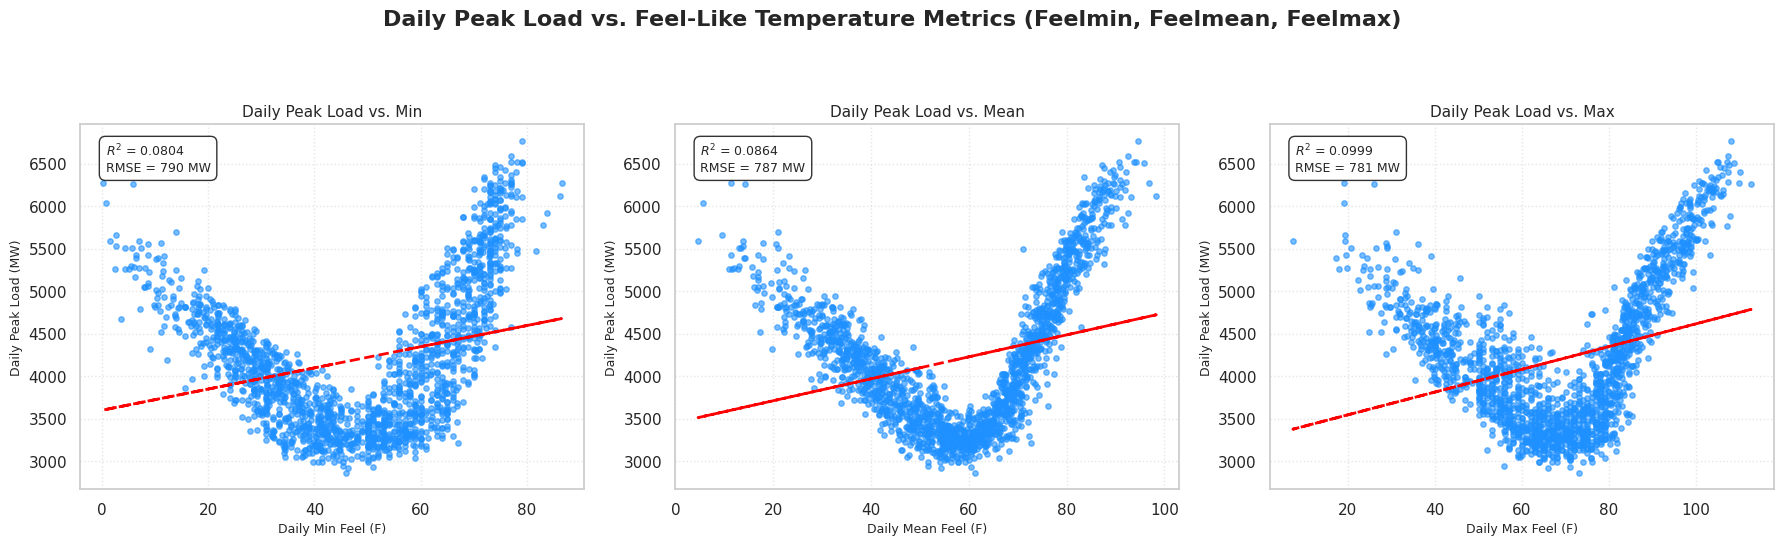

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.metrics import r2_score, mean_squared_error

FILE_PATH = "Final.csv"

def calculate_metrics_and_plot(ax, X, Y, x_label, y_label, title):
    """Performs linear regression, calculates metrics, and plots the results."""

    slope, intercept, r_value, p_value, std_err = linregress(X, Y)

    r_squared = r_value**2
    Y_predicted = slope * X + intercept
    rmse = np.sqrt(mean_squared_error(Y, Y_predicted))

    ax.scatter(X, Y, s=15, alpha=0.6, color='dodgerblue')
    ax.plot(X, Y_predicted, color='red', linestyle='--', linewidth=2,
            label=f'Linear Fit\n($R^2={r_squared:.4f}$)')

    metric_text = (
        r"$R^2$ = " f"{r_squared:.4f}\n"
        f"RMSE = {rmse:.0f} MW"
    )
    ax.text(0.05, 0.95, metric_text, transform=ax.transAxes,
            fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8, ec='black'))

    ax.set_title(title, fontsize=11)
    ax.set_xlabel(x_label, fontsize=9)
    ax.set_ylabel(y_label, fontsize=9)
    ax.grid(True, linestyle=':', alpha=0.5)

def run_daily_analysis(file_path):
    """
    Reads hourly data, aggregates it to daily min/mean/max, and generates
    12 plots comparing daily load to daily meteorology metrics.
    """
    try:
        df = pd.read_csv(file_path, parse_dates=['Time_UTC'])
        df.set_index('Time_UTC', inplace=True)
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found. Please upload it to your execution environment.")
        return

    agg_dict = {
        'mw': ['mean', 'max'],
        'tmpf': ['min', 'mean', 'max'],
        'feel': ['min', 'mean', 'max']
    }

    daily_data = df.resample('D').agg(agg_dict)

    daily_data.columns = ['_'.join(col).strip() for col in daily_data.columns.values]

    daily_data.dropna(inplace=True)

    plot_groups = [
        {'title': 'Daily Mean Load vs. Temperature Metrics (Tmin, Tmean, Tmax)', 'load_col': 'mw_mean', 'load_label': 'Daily Mean Load (MW)', 'weather_prefix': 'tmpf'},
        {'title': 'Daily Peak Load vs. Temperature Metrics (Tmin, Tmean, Tmax)', 'load_col': 'mw_max', 'load_label': 'Daily Peak Load (MW)', 'weather_prefix': 'tmpf'},
        {'title': 'Daily Mean Load vs. Feel-Like Temperature Metrics (Feelmin, Feelmean, Feelmax)', 'load_col': 'mw_mean', 'load_label': 'Daily Mean Load (MW)', 'weather_prefix': 'feel'},
        {'title': 'Daily Peak Load vs. Feel-Like Temperature Metrics (Feelmin, Feelmean, Feelmax)', 'load_col': 'mw_max', 'load_label': 'Daily Peak Load (MW)', 'weather_prefix': 'feel'}
    ]

    weather_stats = ['min', 'mean', 'max']

    for group_index, group in enumerate(plot_groups):
        fig, axes = plt.subplots(1, 3, figsize=(18, 5.5))

        load_col = group['load_col']
        weather_prefix = group['weather_prefix']

        plt.suptitle(group['title'], fontsize=16, fontweight='bold', y=1.02)

        for i, stat in enumerate(weather_stats):
            ax = axes[i]

            weather_col = f'{weather_prefix}_{stat}'
            x_label = f'Daily {stat.capitalize()} {weather_prefix.replace("tmpf", "Temp (F)").replace("feel", "Feel (F)")}'
            y_label = group['load_label']
            plot_title = f'{y_label.replace(" (MW)", "")} vs. {stat.capitalize()}'

            X = daily_data[weather_col]
            Y = daily_data[load_col]

            calculate_metrics_and_plot(ax, X, Y, x_label, y_label, plot_title)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

run_daily_analysis(FILE_PATH)